# Mammographic Mass Data Set

## Data Exploration

###  General Description

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
%matplotlib inline
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report,confusion_matrix

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data'
df = pd.read_csv(url, names=['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity'], sep = ",", na_values = '?')
df.head(10)

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
8,5.0,57.0,1.0,5.0,3.0,1
9,5.0,60.0,NaN,5.0,1.0,1


## B. Missing Category

#### Dealing with Missing Value

In [196]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values ='NaN', strategy = 'mean', axis = 0)

df[['Age']]=imputer.fit_transform(df[['Age']])

C:\Users\aenyd\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [197]:
df["Shape"] = df["Shape"].fillna(0) #https://www.kite.com/python/answers/how-to-replace-nan-values-with-zeros-in-a-column-of-a-pandas-dataframe-in-python
df["Margin"] = df["Margin"].fillna(0)
df["Density"] = df["Density"].fillna(0)

In [198]:
# We drop the BI-RADS because it's non predictive and Change the categorical variables to integer
df2=df.drop(columns=['BI-RADS']).astype(int)
print(df2.dtypes)

Age         int32
Shape       int32
Margin      int32
Density     int32
Severity    int32
dtype: object


In [199]:
#Checking the data type and missing values
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 5 columns):
Age         961 non-null int32
Shape       961 non-null int32
Margin      961 non-null int32
Density     961 non-null int32
Severity    961 non-null int32
dtypes: int32(5)
memory usage: 18.8 KB


In [200]:
df2.head()

,Age,Shape,Margin,Density,Severity
0,67,3,5,3,1
1,43,1,1,0,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,0,1


#### Data Selection

In [201]:
import numpy as np
#transfer into numpy
X = np.array(df2.iloc[:, :-1].values)
y = np.array(df2.iloc[:, -1].values) # class label is contained here

In [202]:
from sklearn.model_selection import train_test_split
splitRatio = 0.8

# Use a random  split of the data
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=(1-splitRatio), random_state=1)

In [203]:
#Check:
print ('X_train dimensions: ', X_train.shape)
print ('y_train dimensions: ', y_train.shape)
print ('X_test dimensions: ', X_test.shape)
print ('y_test dimensions: ', y_test.shape)

X_train dimensions:  (768, 4)
y_train dimensions:  (768,)
X_test dimensions:  (193, 4)
y_test dimensions:  (193,)


### B.1 K-Neirest Neighbors

#### Feature Selection

In [204]:
# we want to see the correlation between pairs of variables
# a basis for feature selection
# This is the data that hasn't been imputed
import matplotlib.pyplot as plt
import seaborn as sns

f=plt.figure(figsize=(19, 15))
corr = df2.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,Shape,Margin,Density,Severity
Age,1,0.329095,0.372997,0.104442,0.430564
Shape,0.329095,1,0.657391,0.169764,0.52603
Margin,0.372997,0.657391,1,0.190525,0.561113
Density,0.104442,0.169764,0.190525,1,0.118445
Severity,0.430564,0.52603,0.561113,0.118445,1


<Figure size 1368x1080 with 0 Axes>

In [205]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = df2.iloc[:, 0:4]  #independent columns
y = df2.iloc[:,-1]    #target column 
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=4)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(4,'Score'))  #print 10 best features

  Features       Score
0      Age  669.037843
2   Margin  307.508052
1    Shape  174.097572
3  Density    3.773123


From the correlation matrix and Best feature ranking above, we can narrow down the features to Age, Shape and Margin. We will then manually try all the possible combination of features and pick the best one.

#### Redefining the Data Selection

In [206]:
# Based on the trying all the best combinantions, the highest performance was performed by Age, Shape and Margin
X_knn = np.array(df2.iloc[:, [0,1,2]].values)
y_knn = np.array(df2.iloc[:, -1].values) # class label is contained here

In [207]:
splitRatio = 0.8

# Use a random  split of the data
X_train2, X_test2, y_knn_train3, y_knn_test3 = \
        train_test_split(X_knn, y_knn, test_size=(1-splitRatio), random_state=0)

In [208]:
mms = MinMaxScaler()
X_knn_train3 = mms.fit_transform(X_train2)
X_knn_test3 = mms.transform(X_test2)

X_knn_train3
X_knn_test3

array([[0.32051282, 0.75      , 0.8       ],
       [0.34615385, 0.25      , 0.2       ],
       [0.53846154, 0.5       , 0.2       ],
       [0.06410256, 0.5       , 0.2       ],
       [0.47435897, 0.5       , 0.2       ],
       [0.62820513, 1.        , 0.8       ],
       [0.48717949, 0.25      , 0.2       ],
       [0.67948718, 0.5       , 0.8       ],
       [0.41025641, 0.5       , 0.2       ],
       [0.62820513, 1.        , 0.2       ],
       [0.46153846, 1.        , 0.8       ],
       [0.5       , 0.25      , 0.2       ],
       [0.79487179, 1.        , 1.        ],
       [0.3974359 , 0.5       , 0.2       ],
       [0.74358974, 1.        , 0.6       ],
       [0.62820513, 1.        , 0.4       ],
       [0.53846154, 1.        , 0.6       ],
       [0.41025641, 1.        , 1.        ],
       [0.67948718, 1.        , 0.8       ],
       [0.23076923, 0.25      , 0.2       ],
       [0.55128205, 0.75      , 0.8       ],
       [0.56410256, 0.75      , 0.6       ],
       [0.

In [209]:
#Check:
print ('X_knn_train3 dimensions: ', X_knn_train3.shape)
print ('y_knn_train3 dimensions: ', y_knn_train3.shape)
print ('X_knn_test3 dimensions: ', X_knn_test3.shape)
print ('y_knn_test3 dimensions: ', y_knn_test3.shape)

X_knn_train3 dimensions:  (768, 3)
y_knn_train3 dimensions:  (768,)
X_knn_test3 dimensions:  (193, 3)
y_knn_test3 dimensions:  (193,)


#### Training the Dataset with Default KNN Classifier

In [210]:
#solution
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
clf_knn=clf_knn.fit(X_knn_train3, y_knn_train3)

In [211]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# We use a utility to generate artificial classification data.
y_knn_pred_def = clf_knn.predict(X_knn_train3)
print('F1 score: %.4f' % f1_score(y_knn_train3, y_knn_pred_def))
print('Precision: %.4f' %precision_score(y_knn_train3, y_knn_pred_def))
print('Recall: %.4f' %recall_score(y_knn_train3, y_knn_pred_def))
print('Accuracy: %.4f' %accuracy_score(y_knn_train3, y_knn_pred_def))

F1 score: 0.8294
Precision: 0.8103
Recall: 0.8494
Accuracy: 0.8398


In [212]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
# Note the use of labels for set 1=True to upper left and 0=False to lower right
confusion_matrix(y_knn_train3, y_knn_pred_def, labels=[1, 0])

Confusion Matrix


array([[299,  53],
       [ 70, 346]], dtype=int64)

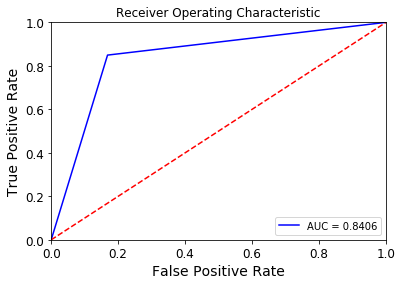

In [213]:
from sklearn import metrics
from sklearn import neighbors
%matplotlib inline

fpr, tpr, threshold = metrics.roc_curve(y_knn_train3, y_knn_pred_def)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Testing the Data Set Using the Default Hyperparameter

In [214]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# We use a utility to generate artificial classification data.
y_knn_pred_def2 = clf_knn.predict(X_knn_test3)

print('Precision: %.4f' %precision_score(y_knn_test3, y_knn_pred_def2))
print('Accuracy: %.4f' %accuracy_score(y_knn_test3, y_knn_pred_def2))
print('Recall: %.4f' %recall_score(y_knn_test3, y_knn_pred_def2))
print('F1 score: %.4f' % f1_score(y_knn_test3, y_knn_pred_def2))

Precision: 0.7872
Accuracy: 0.7979
Recall: 0.7957
F1 score: 0.7914


In [215]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
# Note the use of labels for set 1=True to upper left and 0=False to lower right
confusion_matrix(y_knn_test3, y_knn_pred_def2, labels=[1, 0])

Confusion Matrix


array([[74, 19],
       [20, 80]], dtype=int64)

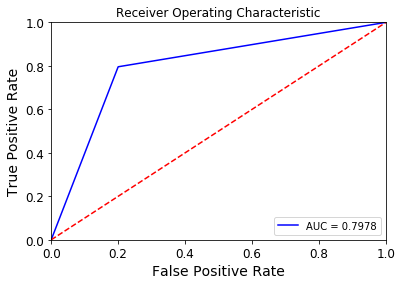

In [216]:
from sklearn import metrics
from sklearn import neighbors
%matplotlib inline

fpr, tpr, threshold = metrics.roc_curve(y_knn_test3, y_knn_pred_def2)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Using GridSearch CV to find the best Hyperparameter Tuning

In [217]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

kn = KNeighborsClassifier()

k_range=list(range(1,100,2))

parameter_grid = {'algorithm':['auto'], 'metric':['minkowski', 'euclidean'],
                     'metric_params':[None], 'n_jobs':[None], 'n_neighbors':k_range, 'p':[2],
                     'weights':['uniform', 'distance']}

grid_kn = GridSearchCV(estimator = kn, scoring = 'precision', param_grid = parameter_grid,
                          cv = 10, verbose=1)

grid_kn.fit(X_knn_train3, y_knn_train3)

print ("Best Score: {}".format(grid_kn.best_score_))
print ("Best params: {}".format(grid_kn.best_params_))
print ("Best estimators: {}".format(grid_dt.best_estimator_))

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score: 0.7808367019214849
Best params: {'algorithm': 'auto', 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Best estimators: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    8.9s finished
C:\Users\aenyd\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Training with Optimized Hyperparameters chosen from the GridSearch CV

In [218]:
#solution
from sklearn.neighbors import KNeighborsClassifier
clf_knn_1 = KNeighborsClassifier(n_neighbors=7, metric='minkowski')

clf_knn_1.fit(X_knn_train3, y_knn_train3)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [219]:
# We use a utility to generate artificial classification data.
y_knn_pred_train = clf_knn_1.predict(X_knn_train3)

print('Precision: %.4f' %precision_score(y_knn_train3, y_knn_pred_train))
print('Accuracy: %.4f' %accuracy_score(y_knn_train3, y_knn_pred_train))
print('Recall: %.4f' %recall_score(y_knn_train3, y_knn_pred_train))
print('F1 score: %.4f' % f1_score(y_knn_train3, y_knn_pred_train))

Precision: 0.7947
Accuracy: 0.8333
Recall: 0.8580
F1 score: 0.8251


In [220]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
# Note the use of labels for set 1=True to upper left and 0=False to lower right
confusion_matrix(y_knn_train3, y_knn_pred_train, labels=[1, 0])

Confusion Matrix


array([[302,  50],
       [ 78, 338]], dtype=int64)

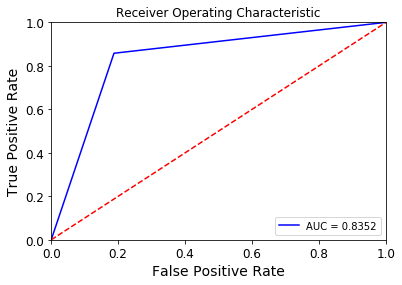

In [221]:
from sklearn import metrics
from sklearn import neighbors
%matplotlib inline

fpr, tpr, threshold = metrics.roc_curve(y_knn_train3, y_knn_pred_train)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Testing the Dataset with the Optimized Hyperparameters and Evaluation Performance

In [222]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# We use a utility to generate artificial classification data.
y_knn_pred_4 = clf_knn_1.predict(X_knn_test3)

print('Precision: %.4f' %precision_score(y_knn_test3, y_knn_pred_4))
print('Accuracy: %.4f' %accuracy_score(y_knn_test3, y_knn_pred_4))
print('Recall: %.4f' %recall_score(y_knn_test3, y_knn_pred_4))
print('F1 score: %.4f' % f1_score(y_knn_test3, y_knn_pred_4))

Precision: 0.7895
Accuracy: 0.8031
Recall: 0.8065
F1 score: 0.7979


In [223]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
# Note the use of labels for set 1=True to upper left and 0=False to lower right
confusion_matrix(y_knn_test3, y_knn_pred_4, labels=[1, 0])

Confusion Matrix


array([[75, 18],
       [20, 80]], dtype=int64)

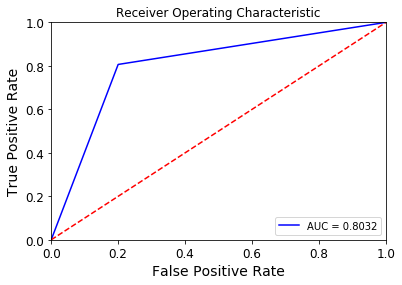

In [224]:
from sklearn import metrics
from sklearn import neighbors
%matplotlib inline

fpr, tpr, threshold = metrics.roc_curve(y_knn_test3, y_knn_pred_4)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Sensitivity Analysis

In [225]:
# Create Decision Tree classifer object
sens_knn = KNeighborsClassifier(n_neighbors=1, metric='minkowski')

sens_knn=sens_knn.fit(X_knn_train3, y_knn_train3)

In [226]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# We use a utility to generate artificial classification data.
y_knn_pred_sens = sens_knn.predict(X_knn_test3)

print('Precision: %.4f' %precision_score(y_knn_test3, y_knn_pred_sens))
print('Accuracy: %.4f' %accuracy_score(y_knn_test3, y_knn_pred_sens))
print('Recall: %.4f' %recall_score(y_knn_test3, y_knn_pred_sens))
print('F1 score: %.4f' % f1_score(y_knn_test3, y_knn_pred_sens))

Precision: 0.7619
Accuracy: 0.7461
Recall: 0.6882
F1 score: 0.7232


In [227]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
# Note the use of labels for set 1=True to upper left and 0=False to lower right
confusion_matrix(y_knn_test3, y_knn_pred_sens, labels=[1, 0])

Confusion Matrix


array([[64, 29],
       [20, 80]], dtype=int64)

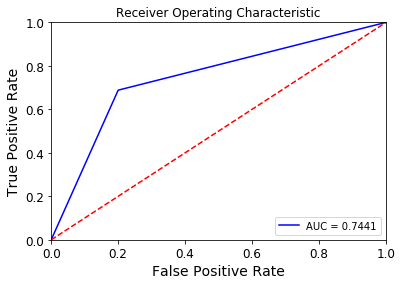

In [228]:
from sklearn import metrics
from sklearn import neighbors
%matplotlib inline

fpr, tpr, threshold = metrics.roc_curve(y_knn_test3, y_knn_pred_sens)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## B.2 Decision Tree Classifier

### B.2.1 Feature Engineering

#### Redifining Data Selection

In [229]:
# Based on the trying all the best combinantions, the highest performance was performed by Age and Shape
X_dt = np.array(df2.iloc[:, [0,1]].values)
y_dt = np.array(df2.iloc[:, -1].values) # class label is contained here

In [230]:
splitRatio = 0.8

# Use a random  split of the data
X_dt_train1, X_dt_test1, y_dt_train1, y_dt_test1 = \
        train_test_split(X_dt, y_dt, test_size=(1-splitRatio), random_state=0)

In [231]:
#Check:
print ('X_dt_train1 dimensions: ', X_dt_train1.shape)
print ('y_dt_train1 dimensions: ', y_dt_train1.shape)
print ('X_dt_test1 dimensions: ', X_dt_test1.shape)
print ('y_dt_test1 dimensions: ', y_dt_test1.shape)

X_dt_train1 dimensions:  (768, 2)
y_dt_train1 dimensions:  (768,)
X_dt_test1 dimensions:  (193, 2)
y_dt_test1 dimensions:  (193,)


#### Training the Model Using the Default Hyperparameter

In [232]:
# Create Decision Tree classifer object
clf_dt = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf_dt = clf_dt.fit(X_dt_train1,y_dt_train1)

In [233]:
#Predict the response for test dataset
y_dt_pred_def = clf_dt.predict(X_dt_train1)


print('Precision: %.4f' %precision_score(y_dt_train1, y_dt_pred_def))
print('Accuracy: %.4f' %accuracy_score(y_dt_train1, y_dt_pred_def))
print('Recall: %.4f' %recall_score(y_dt_train1, y_dt_pred_def))
print('F1 score: %.4f' % f1_score(y_dt_train1, y_dt_pred_def))

Precision: 0.8309
Accuracy: 0.8424
Recall: 0.8239
F1 score: 0.8274


In [234]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
# Note the use of labels for set 1=True to upper left and 0=False to lower right
confusion_matrix(y_dt_train1, y_dt_pred_def, labels=[1, 0])

Confusion Matrix


array([[290,  62],
       [ 59, 357]], dtype=int64)

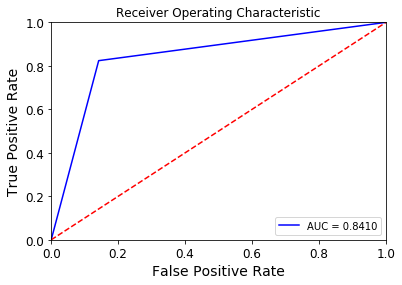

In [235]:
from sklearn import metrics
from sklearn import neighbors
%matplotlib inline

fpr, tpr, threshold = metrics.roc_curve(y_dt_train1, y_dt_pred_def)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Testing the Test Dataset with the Default Hyperparameters

In [236]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# We use a utility to generate artificial classification data.
y_dt_pred_def2 = clf_dt.predict(X_dt_test1)

print('Precision: %.4f' %precision_score(y_dt_test1, y_dt_pred_def2))
print('Accuracy: %.4f' %accuracy_score(y_dt_test1, y_dt_pred_def2))
print('Recall: %.4f' %recall_score(y_dt_test1, y_dt_pred_def2))
print('F1 score: %.4f' % f1_score(y_dt_test1, y_dt_pred_def2))

Precision: 0.7604
Accuracy: 0.7772
Recall: 0.7849
F1 score: 0.7725


In [237]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
# Note the use of labels for set 1=True to upper left and 0=False to lower right
confusion_matrix(y_dt_test1, y_dt_pred_def2, labels=[1, 0])

Confusion Matrix


array([[73, 20],
       [23, 77]], dtype=int64)

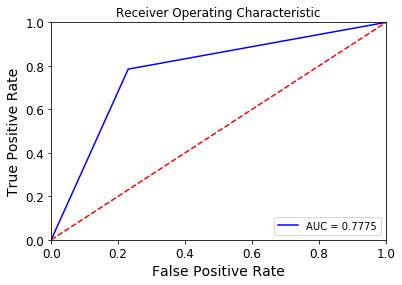

In [238]:
from sklearn import metrics
from sklearn import neighbors
%matplotlib inline

fpr, tpr, threshold = metrics.roc_curve(y_dt_test1, y_dt_pred_def2)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Using GridSearch CV to find the Best Hyperparameter Tuning

In [239]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()

parameter_grid = {'max_depth': np.arange(3, 20), 'criterion':('gini', 'entropy'), 'min_samples_split':np.arange(2,10)}

grid_dt = GridSearchCV(estimator = dt, scoring = 'precision', param_grid = parameter_grid,
                          cv = 10, verbose=1)

grid_dt.fit(X_dt_train1, y_dt_train1)

print ("Best Score: {}".format(grid_dt.best_score_))
print ("Best params: {}".format(grid_dt.best_params_))
print ("Best estimators: {}".format(grid_dt.best_estimator_))

Fitting 10 folds for each of 272 candidates, totalling 2720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score: 0.7600700091003797
Best params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
Best estimators: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


[Parallel(n_jobs=1)]: Done 2720 out of 2720 | elapsed:    5.1s finished
C:\Users\aenyd\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Training with Optimized Hyperparameters from GridSearchCV

In [240]:
# Create Decision Tree classifer object
clf2 = DecisionTreeClassifier(max_depth=3, criterion='entropy', min_samples_split=2)

# Train Decision Tree Classifer
clf_dt_1 = clf2.fit(X_dt_train1,y_dt_train1)

In [241]:
# We use a utility to generate artificial classification data.
y_dt_pred_train = clf2.predict(X_dt_train1)

print('Precision: %.4f' %precision_score(y_dt_train1, y_dt_pred_train))
print('Accuracy: %.4f' %accuracy_score(y_dt_train1, y_dt_pred_train))
print('Recall: %.4f' %recall_score(y_dt_train1, y_dt_pred_train))
print('F1 score: %.4f' % f1_score(y_dt_train1, y_dt_pred_train))

Precision: 0.7866
Accuracy: 0.7865
Recall: 0.7330
F1 score: 0.7588


In [242]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
# Note the use of labels for set 1=True to upper left and 0=False to lower right
confusion_matrix(y_dt_train1, y_dt_pred_train, labels=[1, 0])

Confusion Matrix


array([[258,  94],
       [ 70, 346]], dtype=int64)

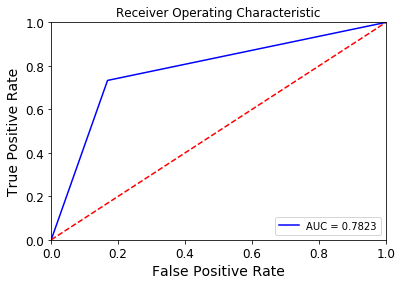

In [243]:
from sklearn import metrics
from sklearn import neighbors
%matplotlib inline

fpr, tpr, threshold = metrics.roc_curve(y_dt_train1, y_dt_pred_train)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Testing the Optimized Model and Performance Evaluation

In [244]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# We use a utility to generate artificial classification data.
y_dt_pred1 = clf2.predict(X_dt_test1)

print('Precision: %.4f' %precision_score(y_dt_test1, y_dt_pred1))
print('Accuracy: %.4f' %accuracy_score(y_dt_test1, y_dt_pred1))
print('Recall: %.4f' %recall_score(y_dt_test1, y_dt_pred1))
print('F1 score: %.4f' % f1_score(y_dt_test1, y_dt_pred1))

Precision: 0.8072
Accuracy: 0.7824
Recall: 0.7204
F1 score: 0.7614


In [245]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
# Note the use of labels for set 1=True to upper left and 0=False to lower right
confusion_matrix(y_dt_test1, y_dt_pred1, labels=[1, 0])

Confusion Matrix


array([[67, 26],
       [16, 84]], dtype=int64)

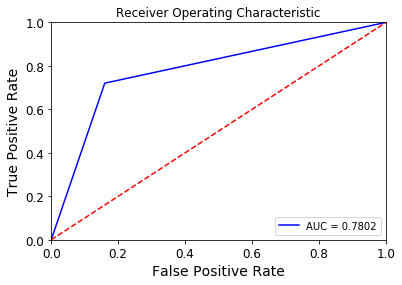

In [246]:
from sklearn import metrics
from sklearn import neighbors
%matplotlib inline

fpr, tpr, threshold = metrics.roc_curve(y_dt_test1, y_dt_pred1)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [247]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

from sklearn.tree import DecisionTreeClassifier

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [248]:
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [249]:
!pip install pydotplus

In [250]:
conda install python-graphviz

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


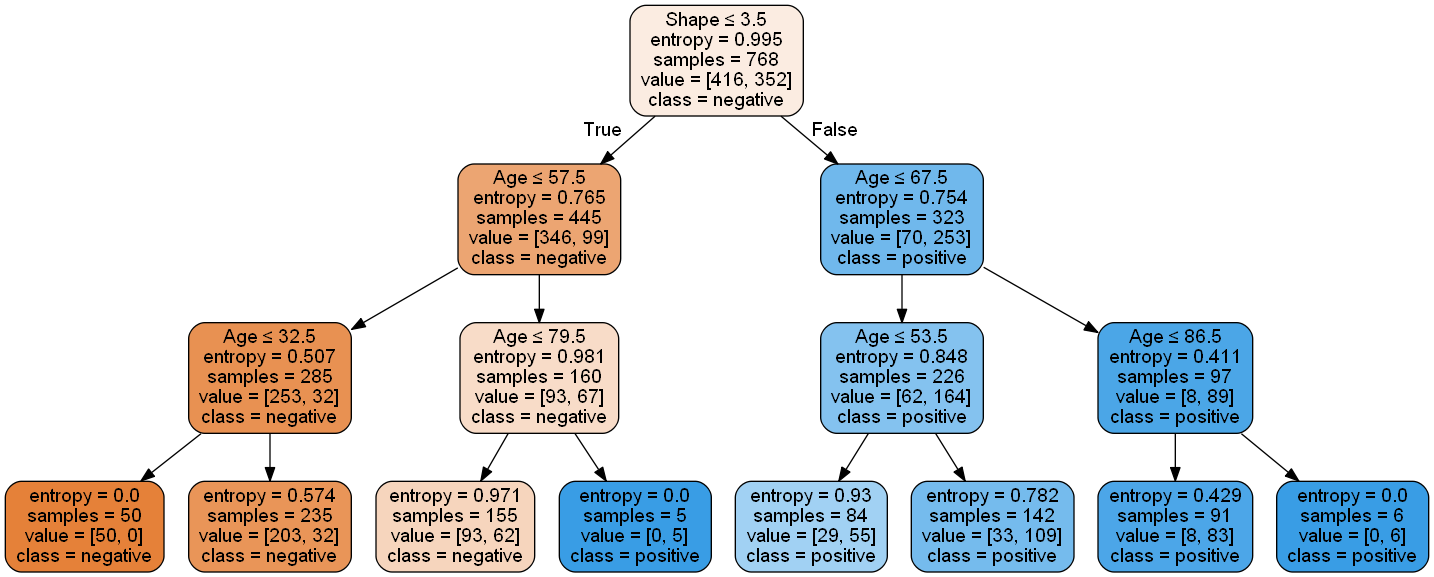

In [251]:
import graphviz 
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
dot_data=StringIO()
cols2=['Age','Shape']
dot_data = export_graphviz(clf_dt_1, out_file = None, feature_names=cols2, class_names=['negative', 'positive'], 
                filled=True, rounded=True, special_characters=True) 

graph = pydotplus.graph_from_dot_data(dot_data)
#print(dot_data)
Image(graph.create_png())

#### Sensitivity Analysis

In [252]:
# Create Decision Tree classifer object
sens_df = DecisionTreeClassifier(max_depth=1, criterion='entropy')

# Train Decision Tree Classifer
sens_df = sens_df.fit(X_dt_train1,y_dt_train1)

In [253]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# We use a utility to generate artificial classification data.
y_dt_pred_sens = sens_df.predict(X_dt_test1)

print('Precision: %.4f' %precision_score(y_dt_test1, y_dt_pred_sens))
print('Accuracy: %.4f' %accuracy_score(y_dt_test1, y_dt_pred_sens))
print('Recall: %.4f' %recall_score(y_dt_test1, y_dt_pred_sens))
print('F1 score: %.4f' % f1_score(y_dt_test1, y_dt_pred_sens))

Precision: 0.8052
Accuracy: 0.7617
Recall: 0.6667
F1 score: 0.7294


In [254]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
# Note the use of labels for set 1=True to upper left and 0=False to lower right
confusion_matrix(y_dt_test1, y_dt_pred_sens, labels=[1, 0])

Confusion Matrix


array([[62, 31],
       [15, 85]], dtype=int64)

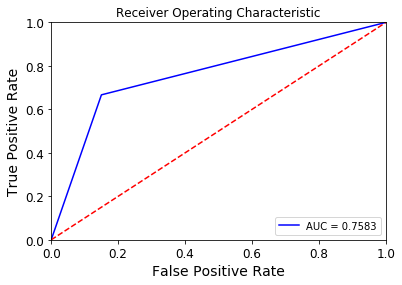

In [255]:
from sklearn import metrics
from sklearn import neighbors
%matplotlib inline

fpr, tpr, threshold = metrics.roc_curve(y_dt_test1, y_dt_pred_sens)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()